In [3]:
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
import os

In [4]:
def camb_clfile(fname, lmax=None):
    with open(fname) as f:
        firstline = next(f)
    keys = [i.lower() for i in firstline.split(' ') if i.isalpha()][1:]
    cols = np.loadtxt(fname).transpose()

    ell = np.int_(cols[0])
    if lmax is None: lmax = ell[-1]
    assert ell[-1] >= lmax, (ell[-1], lmax)

    cls = {k : np.zeros(lmax + 1, dtype=float) for k in keys}

    idc = np.where(ell <= lmax) if lmax is not None else np.arange(len(ell), dtype=int) # type: ignore
    w = lambda ell :ell * (ell + 1) / (2. * np.pi)
    wpp = lambda ell : ell ** 2 * (ell + 1) ** 2 / (2. * np.pi)
    wptpe = lambda ell :np.sqrt(ell.astype(float) ** 3 * (ell + 1.) ** 3) / (2. * np.pi) 
    for i, k in enumerate(keys):
        if k == 'pp':
            we = wpp(ell)
        elif 'p' in k and ('e' in k or 't' in k):
            we = wptpe(ell)
        else:
            we = w(ell)
        cls[k][ell[idc]] = cols[i + 1][idc] / we[idc]
    return cls

def cli(cl):
    ret = np.zeros_like(cl)
    ret[np.where(cl > 0)] = 1. / cl[np.where(cl > 0)]
    return ret

def noise_map(nlep):
    depth_p =np.array(nlep)
    depth_i = depth_p/np.sqrt(2)
    pix_amin2 = 4. * np.pi / float(hp.nside2npix(nside)) * (180. * 60. / np.pi) ** 2
    """sigma_pix_I/P is std of noise per pixel. It is an array of length
    equal to the number of input maps."""
    sigma_pix_I = np.sqrt(depth_i ** 2 / pix_amin2)
    sigma_pix_P = np.sqrt(depth_p ** 2 / pix_amin2)
    npix = hp.nside2npix(nside)
    noise = np.random.randn(len(depth_i), 3, npix)
    noise[:, 0, :] *= sigma_pix_I[:, None]
    noise[:, 1, :] *= sigma_pix_P[:, None]
    noise[:, 2, :] *= sigma_pix_P[:, None]
    return noise

In [5]:
path = 'Data'
cmbdir = 'Data'
massdir = 'Data'
spectradir ='Data/CAMB'

In [6]:
cl_len = camb_clfile(os.path.join(spectradir,'BBSims_lensed_dls.dat'))
cl_unl = camb_clfile(os.path.join(spectradir,'BBSims_scal_dls.dat'))
cl_pot = camb_clfile(os.path.join(spectradir,'BBSims_lenspotential.dat'))

In [7]:
lmax_ivf = 2048
lmin_ivf = 10 
lmax_qlm = 3000 
nside = 1024 
nlev_p = 5
nlev_t = nlev_p/np.sqrt(2)
beam = 4

In [8]:
def get_cmb(idx):
    fname = os.path.join(cmbdir,f"cmb_sims_{idx:04d}.fits")
    alms = hp.map2alm(hp.read_map(fname,(0,1,2)),lmax=lmax_ivf)
    maps = hp.alm2map(alms,nside)
    return maps

In [9]:
cmb = get_cmb(0)

In [12]:
noise = noise_map([nlev_p])[0]

In [13]:
sky = hp.smoothing(cmb,fwhm=np.radians(beam/60)) + noise

In [14]:
bl = hp.gauss_beam(np.radians(beam/60), lmax=lmax_ivf) * hp.pixwin(nside)[:lmax_ivf + 1]
ftl = cli(cl_len['tt'][:lmax_ivf + 1] + (nlev_t / 60. / 180. * np.pi / bl) ** 2)
fel = cli(cl_len['ee'][:lmax_ivf + 1] + (nlev_p / 60. / 180. * np.pi / bl) ** 2)
fbl = cli(cl_len['bb'][:lmax_ivf + 1] + (nlev_p / 60. / 180. * np.pi / bl) ** 2)
ftl[:lmin_ivf] *= 0.
fel[:lmin_ivf] *= 0.
fbl[:lmin_ivf] *= 0.

In [54]:
def ivf_tlm(xmap,fl,bl):
    lmax_fl = len(fl)-1
    alm = hp.map2alm(xmap, lmax_fl, iter=0)
    xlm = hp.almxfl(alm, fl )#* cli(bl[:len(ftl)]))
    return xlm

def ivf_plm(qumap,fel,fbl,bl):
    lmax_fl = len(fel)-1
    elm,blm = hp.map2alm_spin(qumap,2,lmax=lmax_ivf)
    hp.almxfl(elm,fel,inplace=True)#*cli(bl[:len(fel)]),inplace=True)
    hp.almxfl(blm,fbl,inplace=True)#*cli(bl[:len(fbl)]),inplace=True)
    return elm,blm

In [55]:
def wf_xlm(xlm,cl_xx):
    return hp.almxfl(xlm, cl_xx)

def gtmap(tlm,cltt):
    wftlm = wf_xlm(tlm,cltt)
    lmax = hp.Alm.getlmax(wftlm.size)
    Glm = hp.almxfl(wftlm, -np.sqrt(np.arange(lmax + 1, dtype=float) * (np.arange(1, lmax + 2))))
    return hp.alm2map_spin([Glm, np.zeros_like(Glm)], nside, 1, lmax)

def gpmap(Elm_wf,Blm_wf,spin,nside):
    assert spin in [1, 3]
    lmax = hp.Alm.getlmax(Elm_wf.size)
    if spin == 1:
        fl = np.arange(2, lmax + 3, dtype=float) * (np.arange(-1, lmax))
    elif spin == 3:
        fl = np.arange(-2, lmax - 1, dtype=float) * (np.arange(3, lmax + 4))
    else:
        assert 0
    fl[:spin] *= 0.
    fl = np.sqrt(fl)
    
    return hp.alm2map_spin([hp.almxfl(Elm_wf, fl),hp.almxfl(Blm_wf, fl)], nside, spin, lmax)


In [56]:
def qlm_TT(tmap,ftl,bl,cltt):
    tlm = ivf_tlm(tmap,ftl,bl)
    tmap = hp.alm2map(tlm, nside, lmax=hp.Alm.getlmax(tlm.size))
    G,C = gtmap(tlm,cltt)
    G = G*tmap
    C = C*tmap
    G, C = hp.map2alm_spin([G, C], 1, lmax=lmax_qlm)
    fl = - np.sqrt(np.arange(lmax_qlm + 1, dtype=float) * np.arange(1, lmax_qlm + 2))
    hp.almxfl(G, fl, inplace=True)
    hp.almxfl(C, fl, inplace=True)
    return G

def qlm_PP(qumap,fel,fbl,bl,clee,clbb):
    elm,blm = ivf_plm(qumap,fel,fbl,bl)
    fac = 0.5
    iresQ,iresU = hp.alm2map_spin([elm * fac, blm * fac], nside, 2, hp.Alm.getlmax(elm.size))
    elm_wf = wf_xlm(elm,clee)
    blm_wf = wf_xlm(blm,clbb)
    Gs, Cs = gpmap(elm_wf,blm_wf,3,nside)
    GC = (iresQ - 1j * iresU) * (Gs + 1j * Cs)
    Gs, Cs = gpmap(elm_wf,blm_wf,1,nside)
    GC -= (iresQ + 1j * iresU) * (Gs - 1j * Cs)
    del (iresQ,iresU,Gs,Cs)
    G, C = hp.map2alm_spin([GC.real, GC.imag], 1, lmax=lmax_qlm)
    del GC
    fl = - np.sqrt(np.arange(lmax_qlm + 1, dtype=float) * np.arange(1, lmax_qlm + 2))
    hp.almxfl(G, fl, inplace=True)
    return G


def qlm_MV(tqumap,ftl,fel,fbl,bl,cltt,clee,clbb):
    T = qlm_TT(tqumap[0],ftl,bl,cltt)
    P = qlm_PP(tqumap[1:],fel,fbl,bl,clee,clbb)
    return T+P

In [57]:
qlm_tt = qlm_TT(sky[0],ftl,bl,cl_len['tt'])

In [58]:
qlm_pp = qlm_PP(sky[1:],fel,fbl,bl,cl_len['ee'],cl_len['bb'])

In [59]:
qlm_mv = qlm_MV(sky,ftl,fel,fbl,bl,cl_len['tt'],cl_len['ee'],cl_len['bb'])

In [60]:
def slice_alms(teb, lmax_new):
    lmax = hp.Alm.getlmax(len(teb[0]))
    if lmax_new > lmax:
        raise ValueError('lmax_new must be smaller or equal to lmax')
    elif lmax_new == lmax:
        return teb
    else:
        teb_new = np.zeros((3, hp.Alm.getsize(lmax_new)), dtype=teb.dtype)
        indices_full = hp.Alm.getidx(lmax,*hp.Alm.getlm(lmax_new))
        indices_new = hp.Alm.getidx(lmax_new,*hp.Alm.getlm(lmax_new))
        teb_new[:,indices_new] = teb[:,indices_full]
        return teb_new

In [23]:
iqlm = hp.read_alm(os.path.join(massdir,'phi_sims_0000.fits'))
qmap = hp.alm2map(iqlm,nside)
iqlm = hp.map2alm(qmap,lmax=lmax_qlm)

/tmp/ipykernel_247227/3027647387.py:1: RuntimeWarning: invalid value encountered in divide
  plt.plot(hp.alm2cl(qlm_tt,iqlm)/np.sqrt(hp.alm2cl(qlm_tt)*hp.alm2cl(iqlm)))
/tmp/ipykernel_247227/3027647387.py:2: RuntimeWarning: invalid value encountered in divide
  plt.plot(hp.alm2cl(qlm_pp,iqlm)/np.sqrt(hp.alm2cl(qlm_pp)*hp.alm2cl(iqlm)))
/tmp/ipykernel_247227/3027647387.py:3: RuntimeWarning: invalid value encountered in divide
  plt.plot(hp.alm2cl(qlm_mv,iqlm)/np.sqrt(hp.alm2cl(qlm_mv)*hp.alm2cl(iqlm)))


(0.0, 800.0)

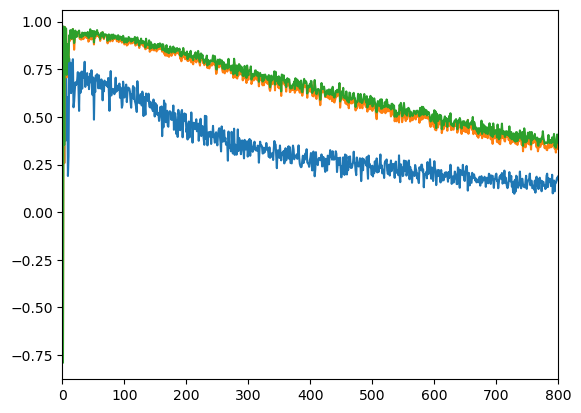

In [62]:
plt.plot(hp.alm2cl(qlm_tt,iqlm)/np.sqrt(hp.alm2cl(qlm_tt)*hp.alm2cl(iqlm)))
plt.plot(hp.alm2cl(qlm_pp,iqlm)/np.sqrt(hp.alm2cl(qlm_pp)*hp.alm2cl(iqlm)))
plt.plot(hp.alm2cl(qlm_mv,iqlm)/np.sqrt(hp.alm2cl(qlm_mv)*hp.alm2cl(iqlm)))
plt.xlim(0,800)

In [28]:
%load_ext autoreload
%autoreload 2
import resNlib as rl

In [30]:

cls_weight = cl_len.copy()

fal_sepTP =  {'tt': cli(cl_len['tt'][:lmax_ivf + 1] + (nlev_t / 60. / 180. * np.pi) ** 2 / bl ** 2),
              'ee': cli(cl_len['ee'][:lmax_ivf + 1] + (nlev_p / 60. / 180. * np.pi) ** 2 / bl ** 2),
              'bb': cli(cl_len['bb'][:lmax_ivf + 1] + (nlev_p / 60. / 180. * np.pi) ** 2 / bl ** 2)}


cls_ivfs_sepTP = {'tt':fal_sepTP['tt'].copy(),
                  'ee':fal_sepTP['ee'].copy(),
                  'bb':fal_sepTP['bb'].copy(),
                  'te':cl_len['te'][:lmax_ivf + 1] * fal_sepTP['tt'] * fal_sepTP['ee']}
cls_dat = {
    'tt': (cl_len['tt'][:lmax_ivf + 1] + (nlev_t / 60. /180. * np.pi) ** 2 / bl ** 2),
    'ee': (cl_len['ee'][:lmax_ivf + 1] + (nlev_p / 60. /180. * np.pi) ** 2 / bl ** 2),
    'bb': (cl_len['bb'][:lmax_ivf + 1] + (nlev_p / 60. /180. * np.pi) ** 2 / bl ** 2),
    'te':  np.copy(cl_len['te'][:lmax_ivf + 1]) }

In [31]:
for cls in [fal_sepTP, cls_ivfs_sepTP]:
    for cl in cls.values():
        cl[:max(1, lmin_ivf)] *= 0.

In [32]:
N0 = {}
rf = {}
for qe_key in ['ptt','p_p', 'p']:
    mNG,_,_,_ = rl.get_nhl(qe_key, qe_key, cls_weight, cls_ivfs_sepTP, lmax_ivf, lmax_ivf, lmax_out=lmax_qlm)
    mRG,_,_,_  = rl.get_response(qe_key, lmax_ivf, 'p', cls_weight, cl_len, fal_sepTP, lmax_qlm=lmax_qlm)
    N0[qe_key] = mNG
    rf[qe_key] = mRG

In [50]:
ellp = np.arange(1, lmax_qlm + 1)
w = lambda ell : ell ** 2 *(ell + 1) ** 2  * 0.5 / np.pi
ylabel = r'$10^7\cdot L^2(L + 1)^2 C_L^{\phi\phi} / 2\pi$'

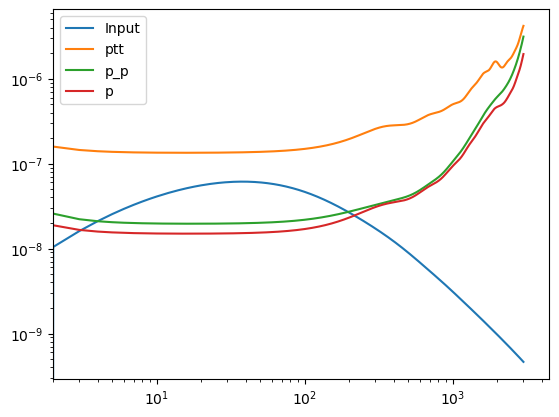

In [51]:
plt.loglog(ellp , w(ellp) * cl_unl['pp'][ellp]*1e-14,label='Input')
plt.xlim(2,None)
for qe_key in ['ptt','p_p', 'p']:
    plt.loglog(ellp, w(ellp) * cli(rf[qe_key][ellp]**2) * N0[qe_key][ellp],label=qe_key)
plt.legend()

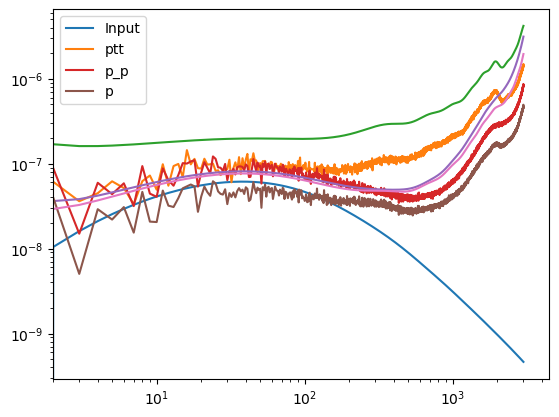

In [63]:
plt.loglog(ellp , w(ellp) * cl_unl['pp'][ellp]*1e-14,label='Input')
plt.xlim(2,None)
for qe_key,recon_i in zip(['ptt','p_p', 'p'],[qlm_tt,qlm_pp,qlm_mv]):
    n0 = cli(rf[qe_key][ellp]**2) * N0[qe_key][ellp]
    sig = hp.alm2cl(recon_i)[ellp] * cli(rf[qe_key][ellp]**2)
    plt.loglog(ellp, w(ellp) * sig,label=qe_key)
    plt.loglog(ellp , w(ellp) * (cl_unl['pp'][ellp]*1e-14+n0),)
plt.legend()